In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import sys
import shutil
import pickle
import seaborn as sns
sns.set_style('whitegrid')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras.models import Model, Sequential, load_model
from keras import optimizers, losses, callbacks, regularizers
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler, Callback
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
with open('/home/jupyter/RL_paper/element_sets/roost_unique_elem_dict.pkl', 'rb') as f:
    roost_elem_dict = pickle.load(f)
element_list = roost_elem_dict['mp-bulk-mod.csv']

In [3]:
def train_model(prop, iteration):
    def counts2vector(pairs):
        vec = [0]*len(element_list)
        for pair in pairs:
            vec[element_list.index(pair[0])]+=int(pair[1])
        vec = np.array(vec)
        return vec

    def onehot(enc):
        rep = np.zeros((84,11))
        rep[:,0] = 1
        for i,val in enumerate(enc):
            if val!=0:
                rep[i][0]=0
                rep[i][val]=1
        return rep.flatten()

    def encode(df_to_encode):
        formulae = df_to_encode[['comp']]
        counts = pd.Series(formulae.values.flatten()).str.findall(r"([a-z]+)([0-9]+)", re.I)
        res = []
        for count in counts:
            res.append(counts2vector(count))
        df_to_encode['encoding'] = res
        # df_to_encode['encoding'] = counts.apply(counts2vector)
        # df_to_encode['onehot'] = df_to_encode['encoding'].apply(onehot)
        res_2 = []
        for encod in res:
            res_2.append(onehot(encod))
        df_to_encode['onehot'] = res_2

    def sample_z(args):
        mu, log_sigma = args
        eps = K.random_normal(shape=(n_z,), mean=0., stddev=1.)
        return mu + K.exp(log_sigma / 2.) * eps

    def vae_loss(y_true, y_pred):

        # Reconstruction Loss
        y_true_reshaped=tf.reshape(y_true,[-1,84,11])
        recon = 10 * K.mean(K.sum(K.categorical_crossentropy(y_true_reshaped, y_pred, axis=2),axis=1))

        # KL Divergence Loss
        kl = 0.05 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

        #Total loss
        return recon + kl

    class DecoderSaveCheckpoint(Callback):
        def __init__(self, filepath, decoder):
            self.monitor = 'val_loss'
            self.monitor_op = np.less
            self.best = np.Inf

            self.filepath = filepath
            self.decoder = decoder

        def on_epoch_end(self, epoch, logs=None):
            current = logs.get(self.monitor)
            if self.monitor_op(current, self.best):
                self.best = current
            self.decoder.save(self.filepath, overwrite=True)
    
    with open(f'/home/jupyter/CJK/RL/paper/data/{prop}_data.pkl', 'rb') as f:
        properties = pickle.load(f)
    df_orig = pd.read_csv('/home/jupyter/CJK/RL/data/mp_all_data_cleaned_oxides_csv.csv')
    
    df = pd.DataFrame()
    df['comp'] = df_orig['pretty_formula_coeff']
    if prop == 'sinter_temp' or prop == 'calcine_temp':
        properties = [x/100 for x in properties]
    df[prop] = properties
    
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    encode(df_train)
    encode(df_test)
    
    X_train = df_train.onehot.values
    X_train = np.stack(X_train,axis=0)
    X_test = df_test.onehot.values
    X_test = np.stack(X_test,axis=0)
    y_train = df_train[[prop]].values
    y_test = df_test[[prop]].values
    
    n_z = 32  # dimension of latent space
    n_x = X_train.shape[1] 
    n_y = y_train.shape[1]

    X = Input(shape=(n_x,))
    cond = Input(shape=(n_y,))

    inputs = Concatenate(axis=1)([X,cond])
    h_q = Dense(512, activation='relu')(inputs)
    h_q1= Dense(256, activation='relu')(h_q)
    h_q2= Dense(128, activation='relu')(h_q1)
    mu = Dense(n_z, activation='linear')(h_q2)
    log_sigma = Dense(n_z, activation='linear')(h_q2)
    
    
    z = Lambda(sample_z)([mu, log_sigma])
    z_cond = Concatenate(axis=1)([z, cond])

    decoder_hidden = Dense(128, activation='relu')
    decoder_hidden_1 = Dense(256, activation='relu')
    decoder_hidden_2 = Dense(512, activation='relu')
    decoder_out = Dense(n_x, activation='linear')
    decoder_out_act = Lambda(lambda x: K.softmax(K.reshape(x,(-1,84,11)), axis=2))

    h_p = decoder_hidden(z_cond)
    h_p1=decoder_hidden_1(h_p)
    h_p2=decoder_hidden_2(h_p1)

    outputs = decoder_out_act(decoder_out(h_p2))
    
    vae = Model([X,cond], outputs)
    
    
    # We use the mean as the output as it is the center point, the representative of the gaussian
    encoder = Model([X,cond], mu)

    # Generator model, generate new data given latent variable z
    d_cond = Input(shape=(n_y,))
    d_z = Input(shape=(n_z,))
    d_inputs = Concatenate(axis=1)([d_z,d_cond])
    d_h = decoder_hidden(d_inputs)
    d_h1 = decoder_hidden_1(d_h)
    d_h2 = decoder_hidden_2(d_h1)
    d_out = decoder_out_act(decoder_out(d_h2))
    decoder = Model([d_z,d_cond], d_out)
    
    vae.compile(optimizer='adam', loss=vae_loss)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=0.00000001,verbose=1)
    
    losses=[]
    checkpoint=callbacks.ModelCheckpoint(filepath=f'Models/{prop}_{iteration}_ding_model_best.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    save_loss = callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: [
            losses.append(logs['val_loss'])])
    
    history = vae.fit([X_train, y_train], X_train, batch_size=256, epochs=150, validation_split=0.2,callbacks=[reduce_lr,checkpoint,save_loss, DecoderSaveCheckpoint(f'Models/{prop}_{iteration}_ding_decoder_best.h5', decoder)])
    
    with open(f'Data/{prop}_{iteration}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    plt.figure(figsize=(10,10))
    plt.plot(vae.history.history['loss'])
    plt.plot(vae.history.history['val_loss'])
    plt.title("Performance of DING model with increase in epochs ")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper right')
    plt.show()
    
    
    Y_pred = vae.predict([X_test,y_test])
    Y_pred = Y_pred.reshape(-1,84,11)
    
    
    # pred encoding stores the coefficients of the elements in the material
    pred_encoding = np.zeros((Y_pred.shape[0],84))
    Y_pred[Y_pred<0.5]=0

    for i,mol in enumerate(Y_pred):
        for j,atom in enumerate(mol):
            if atom.max()!=0:
                pred_encoding[i][j] = atom.argmax()

    test_encoding = np.zeros_like(pred_encoding)
    for i,mol in enumerate(X_test.reshape(-1,84,11)):
        for j,atom in enumerate(mol):
            if atom.max()!=0:
                test_encoding[i][j] = atom.argmax()
                
                
    accuracy = (np.unique(np.sum(np.abs(pred_encoding - test_encoding),axis=1),return_counts=True))[1]*100/len(X_test)
    with open(f'Data/{prop}_{iteration}_reconstruction_accuracy.pkl', 'wb') as f:
        pickle.dump(accuracy, f)

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 97us/step - loss: 332.8374 - val_loss: 170.9982

Epoch 00001: val_loss improved from inf to 170.99820, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 73us/step - loss: 166.9800 - val_loss: 160.9161

Epoch 00002: val_loss improved from 170.99820 to 160.91606, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 71us/step - loss: 160.8932 - val_loss: 157.7715

Epoch 00003: val_loss improved from 160.91606 to 157.77148, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 77us/step - loss: 156.2196 - val_loss: 155.3327

Epoch 00004: val_loss improved from 157.77148 to 155.33269, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoch 5/150
16239/16239 [========================

Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 29.3669 - val_loss: 49.6467

Epoch 00038: val_loss improved from 50.89460 to 49.64668, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 71us/step - loss: 29.4072 - val_loss: 48.1743

Epoch 00039: val_loss improved from 49.64668 to 48.17435, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoch 40/150
16239/16239 [==============================] - 1s 69us/step - loss: 27.0192 - val_loss: 48.9233

Epoch 00040: val_loss did not improve from 48.17435
Epoch 41/150
16239/16239 [==============================] - 1s 68us/step - loss: 25.8986 - val_loss: 48.7373

Epoch 00041: val_loss did not improve from 48.17435
Epoch 42/150
16239/16239 [==============================] - 1s 68us/step - loss: 24.0889 - val_loss: 46.1930

Epoch 00042: val_loss improved from 48.17435 to 46.19302, saving model to Models/sinter_temp_1_ding_model_best.h5
Epoc


Epoch 00082: ReduceLROnPlateau reducing learning rate to 1e-08.

Epoch 00082: val_loss did not improve from 40.48674
Epoch 83/150
16239/16239 [==============================] - 1s 68us/step - loss: 10.0619 - val_loss: 41.0799

Epoch 00083: val_loss did not improve from 40.48674
Epoch 84/150
16239/16239 [==============================] - 1s 67us/step - loss: 10.0170 - val_loss: 41.1823

Epoch 00084: val_loss did not improve from 40.48674
Epoch 85/150
16239/16239 [==============================] - 1s 71us/step - loss: 10.0918 - val_loss: 41.2868

Epoch 00085: val_loss did not improve from 40.48674
Epoch 86/150
16239/16239 [==============================] - 1s 80us/step - loss: 10.1281 - val_loss: 40.8770

Epoch 00086: val_loss did not improve from 40.48674
Epoch 87/150
16239/16239 [==============================] - 1s 68us/step - loss: 9.9972 - val_loss: 41.6250

Epoch 00087: val_loss did not improve from 40.48674
Epoch 88/150
16239/16239 [==============================] - 1s 68us/step 

Epoch 133/150
16239/16239 [==============================] - 1s 69us/step - loss: 10.0359 - val_loss: 41.2165

Epoch 00133: val_loss did not improve from 40.48674
Epoch 134/150
16239/16239 [==============================] - 1s 67us/step - loss: 10.0892 - val_loss: 41.0851

Epoch 00134: val_loss did not improve from 40.48674
Epoch 135/150
16239/16239 [==============================] - 1s 67us/step - loss: 10.0542 - val_loss: 41.3912

Epoch 00135: val_loss did not improve from 40.48674
Epoch 136/150
16239/16239 [==============================] - 1s 81us/step - loss: 10.0920 - val_loss: 41.1829

Epoch 00136: val_loss did not improve from 40.48674
Epoch 137/150
16239/16239 [==============================] - 1s 69us/step - loss: 10.0049 - val_loss: 40.9415

Epoch 00137: val_loss did not improve from 40.48674
Epoch 138/150
16239/16239 [==============================] - 1s 69us/step - loss: 9.9948 - val_loss: 40.9889

Epoch 00138: val_loss did not improve from 40.48674
Epoch 139/150
16239/162

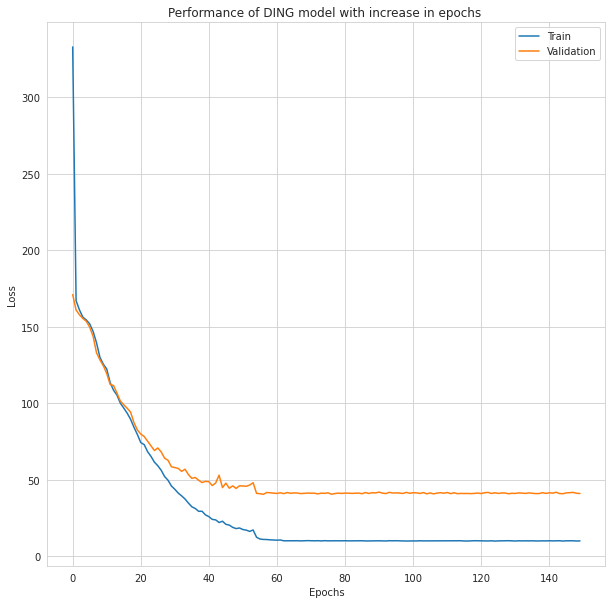

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 103us/step - loss: 331.3303 - val_loss: 169.0467

Epoch 00001: val_loss improved from inf to 169.04673, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 74us/step - loss: 164.7503 - val_loss: 160.2491

Epoch 00002: val_loss improved from 169.04673 to 160.24914, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 68us/step - loss: 158.7224 - val_loss: 157.6013

Epoch 00003: val_loss improved from 160.24914 to 157.60127, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 68us/step - loss: 156.2373 - val_loss: 155.1971

Epoch 00004: val_loss improved from 157.60127 to 155.19711, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoch 5/150
16239/16239 [=======================

Epoch 38/150
16239/16239 [==============================] - 1s 73us/step - loss: 35.6120 - val_loss: 56.9876

Epoch 00038: val_loss did not improve from 55.35882
Epoch 39/150
16239/16239 [==============================] - 1s 72us/step - loss: 33.1337 - val_loss: 50.3551

Epoch 00039: val_loss improved from 55.35882 to 50.35508, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoch 40/150
16239/16239 [==============================] - 1s 68us/step - loss: 31.2564 - val_loss: 49.5651

Epoch 00040: val_loss improved from 50.35508 to 49.56514, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoch 41/150
16239/16239 [==============================] - 1s 68us/step - loss: 29.5203 - val_loss: 49.7550

Epoch 00041: val_loss did not improve from 49.56514
Epoch 42/150
16239/16239 [==============================] - 1s 67us/step - loss: 30.4103 - val_loss: 49.4728

Epoch 00042: val_loss improved from 49.56514 to 49.47275, saving model to Models/sinter_temp_2_ding_model_best.h5
Epoc


Epoch 00082: val_loss did not improve from 42.78457
Epoch 83/150
16239/16239 [==============================] - 1s 70us/step - loss: 13.3906 - val_loss: 43.4054

Epoch 00083: val_loss did not improve from 42.78457
Epoch 84/150
16239/16239 [==============================] - 1s 73us/step - loss: 13.5948 - val_loss: 43.5780

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1e-08.

Epoch 00084: val_loss did not improve from 42.78457
Epoch 85/150
16239/16239 [==============================] - 1s 67us/step - loss: 13.5175 - val_loss: 42.9533

Epoch 00085: val_loss did not improve from 42.78457
Epoch 86/150
16239/16239 [==============================] - 1s 68us/step - loss: 13.5903 - val_loss: 43.5486

Epoch 00086: val_loss did not improve from 42.78457
Epoch 87/150
16239/16239 [==============================] - 1s 67us/step - loss: 13.4955 - val_loss: 43.1811

Epoch 00087: val_loss did not improve from 42.78457
Epoch 88/150
16239/16239 [==============================] - 1s 74us/step


Epoch 00132: val_loss did not improve from 42.78457
Epoch 133/150
16239/16239 [==============================] - 1s 68us/step - loss: 13.4948 - val_loss: 43.5945

Epoch 00133: val_loss did not improve from 42.78457
Epoch 134/150
16239/16239 [==============================] - 1s 68us/step - loss: 13.5068 - val_loss: 43.3038

Epoch 00134: val_loss did not improve from 42.78457
Epoch 135/150
16239/16239 [==============================] - 1s 73us/step - loss: 13.3652 - val_loss: 43.3503

Epoch 00135: val_loss did not improve from 42.78457
Epoch 136/150
16239/16239 [==============================] - 1s 74us/step - loss: 13.4875 - val_loss: 42.9055

Epoch 00136: val_loss did not improve from 42.78457
Epoch 137/150
16239/16239 [==============================] - 1s 69us/step - loss: 13.5409 - val_loss: 43.4142

Epoch 00137: val_loss did not improve from 42.78457
Epoch 138/150
16239/16239 [==============================] - 1s 71us/step - loss: 13.5637 - val_loss: 42.9890

Epoch 00138: val_loss

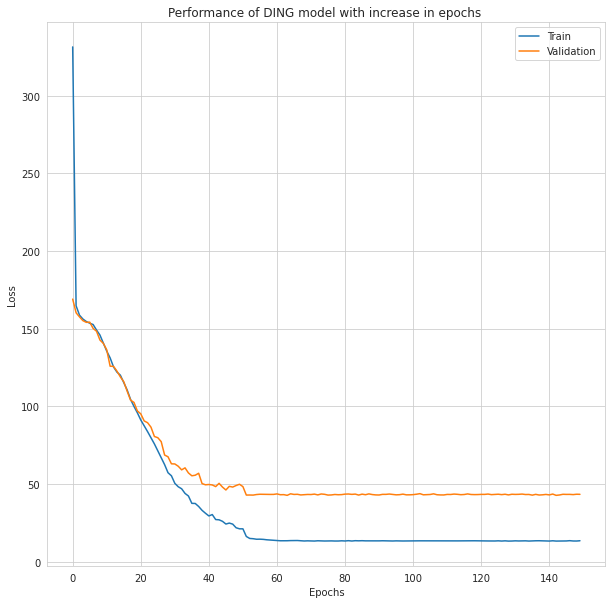

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 105us/step - loss: 325.7785 - val_loss: 172.4563

Epoch 00001: val_loss improved from inf to 172.45634, saving model to Models/sinter_temp_3_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 71us/step - loss: 168.7907 - val_loss: 166.9776

Epoch 00002: val_loss improved from 172.45634 to 166.97755, saving model to Models/sinter_temp_3_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 69us/step - loss: 164.1985 - val_loss: 173.4458

Epoch 00003: val_loss did not improve from 166.97755
Epoch 4/150
16239/16239 [==============================] - 1s 68us/step - loss: 163.2574 - val_loss: 159.4793

Epoch 00004: val_loss improved from 166.97755 to 159.47929, saving model to Models/sinter_temp_3_ding_model_best.h5
Epoch 5/150
16239/16239 [==============================] - 1s 70us/step - loss: 157.2490 - val_loss: 164.7401



16239/16239 [==============================] - 1s 77us/step - loss: 38.5886 - val_loss: 56.2660

Epoch 00039: val_loss did not improve from 55.85532
Epoch 40/150
16239/16239 [==============================] - 1s 72us/step - loss: 36.2271 - val_loss: 55.1057

Epoch 00040: val_loss improved from 55.85532 to 55.10571, saving model to Models/sinter_temp_3_ding_model_best.h5
Epoch 41/150
16239/16239 [==============================] - 1s 71us/step - loss: 34.1540 - val_loss: 53.6964

Epoch 00041: val_loss improved from 55.10571 to 53.69640, saving model to Models/sinter_temp_3_ding_model_best.h5
Epoch 42/150
16239/16239 [==============================] - 1s 70us/step - loss: 33.1859 - val_loss: 51.3122

Epoch 00042: val_loss improved from 53.69640 to 51.31215, saving model to Models/sinter_temp_3_ding_model_best.h5
Epoch 43/150
16239/16239 [==============================] - 1s 68us/step - loss: 31.6432 - val_loss: 51.0423

Epoch 00043: val_loss improved from 51.31215 to 51.04231, saving mode


Epoch 00083: val_loss did not improve from 44.06251
Epoch 84/150
16239/16239 [==============================] - 1s 71us/step - loss: 16.8388 - val_loss: 44.2041

Epoch 00084: val_loss did not improve from 44.06251
Epoch 85/150
16239/16239 [==============================] - 1s 68us/step - loss: 16.9615 - val_loss: 44.4308

Epoch 00085: val_loss did not improve from 44.06251
Epoch 86/150
16239/16239 [==============================] - 1s 68us/step - loss: 16.9889 - val_loss: 44.4510

Epoch 00086: val_loss did not improve from 44.06251
Epoch 87/150
16239/16239 [==============================] - 1s 80us/step - loss: 16.9509 - val_loss: 44.3485

Epoch 00087: val_loss did not improve from 44.06251
Epoch 88/150
16239/16239 [==============================] - 1s 69us/step - loss: 16.8335 - val_loss: 44.5753

Epoch 00088: val_loss did not improve from 44.06251
Epoch 89/150
16239/16239 [==============================] - 1s 68us/step - loss: 16.7312 - val_loss: 44.4026

Epoch 00089: val_loss did n

16239/16239 [==============================] - 1s 68us/step - loss: 16.8203 - val_loss: 44.3737

Epoch 00133: val_loss did not improve from 43.85856
Epoch 134/150
16239/16239 [==============================] - 1s 73us/step - loss: 16.7385 - val_loss: 44.3278

Epoch 00134: val_loss did not improve from 43.85856
Epoch 135/150
16239/16239 [==============================] - 1s 68us/step - loss: 16.7794 - val_loss: 44.2795

Epoch 00135: val_loss did not improve from 43.85856
Epoch 136/150
16239/16239 [==============================] - 1s 69us/step - loss: 16.8470 - val_loss: 44.3918

Epoch 00136: val_loss did not improve from 43.85856
Epoch 137/150
16239/16239 [==============================] - 1s 74us/step - loss: 16.7954 - val_loss: 44.0560

Epoch 00137: val_loss did not improve from 43.85856
Epoch 138/150
16239/16239 [==============================] - 1s 69us/step - loss: 16.7671 - val_loss: 44.1783

Epoch 00138: val_loss did not improve from 43.85856
Epoch 139/150
16239/16239 [=========

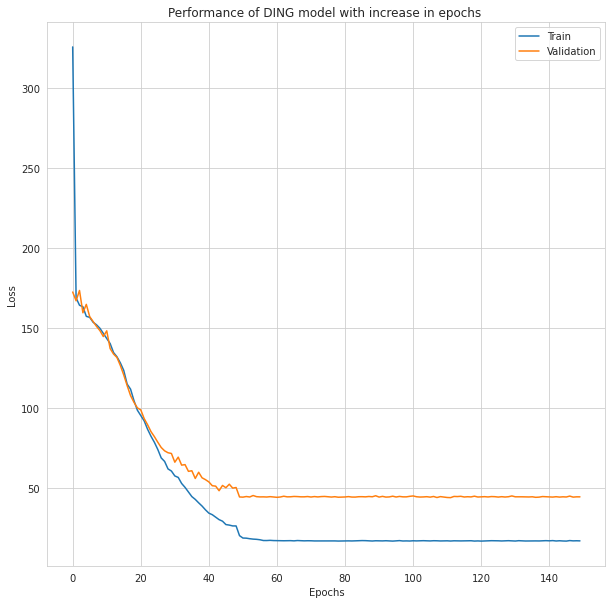

In [4]:
# for prop in ['form_e', 'band_gap', 'bulk_mod', 'shear_mod', 'sinter_temp', 'calcine_temp']:
for prop in ['sinter_temp']:
    for iteration in range(1, 4):
        train_model(prop, str(iteration))